In [2]:
from numpy.random import default_rng as random_number_generator, Generator as RNG
from tp.schelling import mercado_inmobiliario
from typing import Optional
from tp.util.barrios import Mapa
from tp.util.types import Lattice
from tp.util import simulador
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from definiciones import (
    graficar_gini, 
    gini, 
    criterio_equilibrio, 
    gini_barrio, 
    satisfechos_en,
    crear_modelo,
    crear_simulador
)


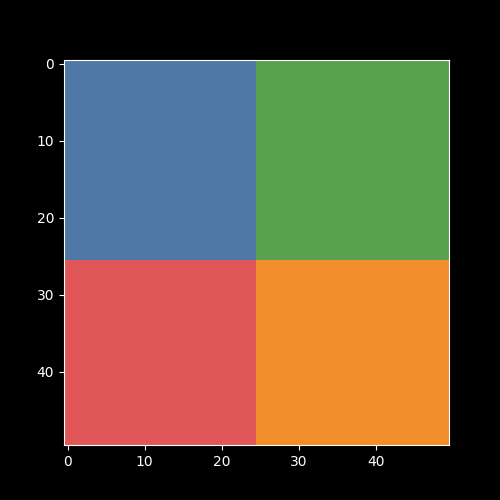

In [3]:
N = 50
alphas = [.1, .4, .8]
rangos_de_vision = np.linspace(0,1, 10)

rng = random_number_generator(seed=1)
m = Mapa.load(mapa='./tp/mapas/cuatro_cuadrantes.txt',  barrios='./tp/barrios.json')
m.as_image();
m.show()

caching_actions = (
    mercado_inmobiliario.utilidad_media,
    mercado_inmobiliario.capital_medio,
    # gini_barrio(0),
    # gini_barrio(1),
    # gini_barrio(2),
    # gini_barrio(3),
    # satisfechos_en(0),
    # satisfechos_en(1),
    # satisfechos_en(2),
    # satisfechos_en(3),
)

In [4]:
M = len(alphas) * len(rangos_de_vision)
config_iniciales = rng.uniform(0, 10, (M, N, N))  # M matrices de NxN

In [5]:
modelos = [None for _ in range(M)]
simuladores = [crear_simulador(caching_actions) for _ in range(M)]

i = 0
for alpha in alphas:
    for r in rangos_de_vision:
        modelos[i] = crear_modelo(alpha, r, rng, m, capital_inicial=config_iniciales[i])
        simuladores[i] = simuladores[i](modelos[i])
        i += 1

In [6]:
for sim in tqdm(simuladores):
    sim.run()

  0%|          | 0/30 [00:00<?, ?it/s]

La simulación alcanzó el equilibrio en 20 pasos.
La simulación alcanzó el equilibrio en 142 pasos.
La simulación alcanzó el equilibrio en 87 pasos.
La simulación alcanzó el equilibrio en 73 pasos.
La simulación alcanzó el equilibrio en 66 pasos.
La simulación alcanzó el equilibrio en 72 pasos.
La simulación alcanzó el equilibrio en 64 pasos.
La simulación alcanzó el equilibrio en 79 pasos.
La simulación alcanzó el equilibrio en 74 pasos.
La simulación alcanzó el equilibrio en 69 pasos.
La simulación alcanzó el equilibrio en 20 pasos.
La simulación alcanzó el equilibrio en 105 pasos.
La simulación alcanzó el equilibrio en 115 pasos.
La simulación alcanzó el equilibrio en 145 pasos.
La simulación no alcanzó el equilibrio en 149 pasos.
La simulación no alcanzó el equilibrio en 149 pasos.
La simulación no alcanzó el equilibrio en 149 pasos.
La simulación alcanzó el equilibrio en 134 pasos.
La simulación no alcanzó el equilibrio en 149 pasos.
La simulación alcanzó el equilibrio en 125 pasos

In [12]:
resultados_por_alpha = dict()

for i in range(0,30,10):
    alpha = alphas[i//10]
    resultados_por_alpha[alpha] = simuladores[i:i+10]

In [13]:
from fundar import json
from fundar.json import JSONEncoder

In [14]:
class JsonEncoder(JSONEncoder):
    def default(self, o: object):
        if isinstance(o, np.ndarray):
            return list(o)
        if isinstance(o, np.floating):
            return float(o)
        if isinstance(o, np.integer):
            return int(o)

In [56]:
result = []

for s in simuladores:
    observaciones = s._cache
    alpha = s.modelo.alpha
    rango = s.modelo.rango_de_vision
    satisfechos_finales = s.modelo.satisfechos().sum()
    result.append({
        'observaciones': observaciones,
        'alpha': alpha,
        'rango': rango,
        'satisfechos': [
            satisfechos_en(0)(s.modelo),
            satisfechos_en(1)(s.modelo),
            satisfechos_en(2)(s.modelo),
            satisfechos_en(3)(s.modelo)
        ]
    })

json.dump(result, 'test.json', cls=JsonEncoder)

In [57]:
caches = json.load('test.json')

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

plt.ion()
plt.style.use('ggplot')

In [79]:
satisfaccion_por_rango_alpha01 = dict[float, list[float]]()
satisfaccion_por_rango_alpha04 = dict[float, list[float]]()
satisfaccion_por_rango_alpha08 = dict[float, list[float]]()

for cache in caches:
    alpha = cache['alpha']
    rango = cache['rango']

    if alpha == .8:
        for satisfaccion in cache['satisfechos']:
            satisfaccion_por_rango_alpha08.setdefault(rango, []).append(satisfaccion)

    if alpha == .4:
        for satisfaccion in cache['satisfechos']:
            satisfaccion_por_rango_alpha04.setdefault(rango, []).append(satisfaccion)

    if alpha == .1:
        for satisfaccion in cache['satisfechos']:
            satisfaccion_por_rango_alpha01.setdefault(rango, []).append(satisfaccion)

In [95]:
habitantes_por_barrio = [
    (m.mapa == i).sum()
    for i in range(4)
]

(0.0, 100.0)

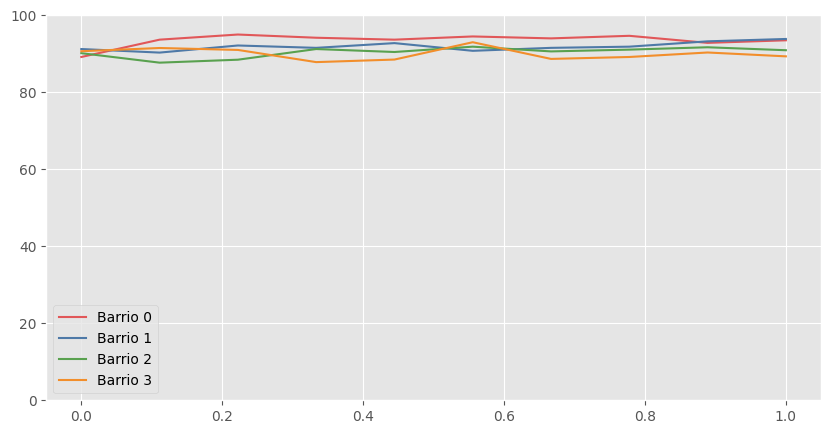

In [100]:
df = pd.DataFrame(satisfaccion_por_rango_alpha08).T
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(100*df[i]/habitantes_por_barrio[i], label=f'Barrio {i}', color=m.barrios[i].color)

legend = plt.legend()
for t in legend.get_texts():
    t.set_color('black')

plt.ylim(0,100)

(0.0, 100.0)

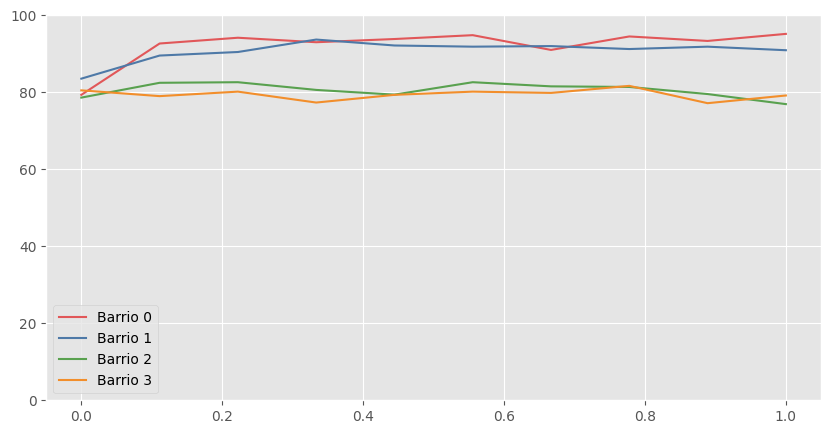

In [101]:
df = pd.DataFrame(satisfaccion_por_rango_alpha04).T
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(100*df[i]/habitantes_por_barrio[i], label=f'Barrio {i}', color=m.barrios[i].color)

legend = plt.legend()
for t in legend.get_texts():
    t.set_color('black')

plt.ylim(0,100)


(0.0, 100.0)

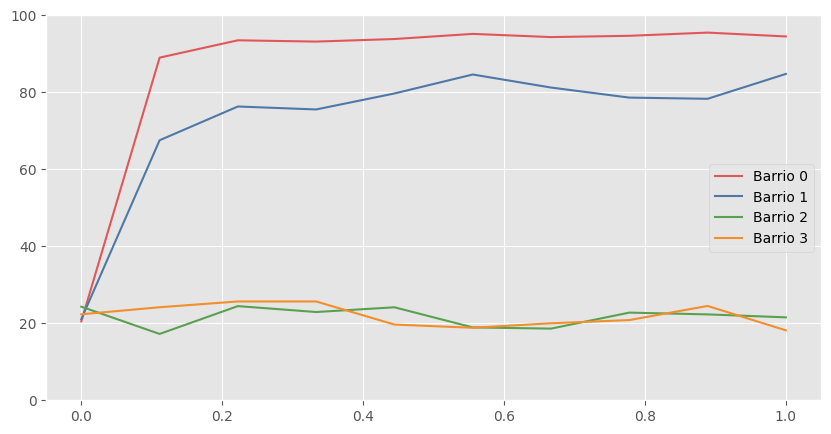

In [102]:
df = pd.DataFrame(satisfaccion_por_rango_alpha01).T
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(100*df[i]/habitantes_por_barrio[i], label=f'Barrio {i}', color=m.barrios[i].color)

legend = plt.legend()
for t in legend.get_texts():
    t.set_color('black')

plt.ylim(0,100)


In [ ]:
ax = pd.DataFrame(satisfechos_por_alpha).plot()

In [ ]:
plt.imshow(modelo.K, cmap='grey', norm=plt.Normalize(0, range_max))
plt.colorbar()
plt.show()

In [ ]:
plt.style.use('ggplot')

In [ ]:
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(sim._cache[f'gini_barrio_{i}'], label=f'Barrio {i}', color=m.barrios[i].color)

legend = plt.legend()
for t in legend.get_texts():
    t.set_color('black')

In [ ]:
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(sim._cache[f'satisfechos_en_{i}'], label=f'Barrio {i}', color=m.barrios[i].color)

legend = plt.legend()
for t in legend.get_texts():
    t.set_color('black')

In [ ]:
data = config_inicial.flatten()
plot = graficar_gini(data, gini(data))
plot.title('Índice de Gini total inicial', color='black')
plot.show()

In [ ]:
data = modelo.K.flatten()
plot = graficar_gini(data, gini(data))
plot.title('Índice de Gini total final', color='black')
plot.show()